# Triplet NN for signature validation using Keras

This code is inspired from KinWaiCheuk [github repository](https://github.com/KinWaiCheuk/Triplet-net-keras).
For a good intruduction about Triplet net (also know as triplet loss) see [Triplet Loss and Online Triplet Mining in TensorFlow](https://omoindrot.github.io/triplet-loss) by Olivier Moindrot.

Here I am using triplet NN to validade signatures. The idea is that:
* Two examples of genuine signatures from the same person have their embeddings close together in the embedding space
* A genuine signature and a forged one have their embeddings far away.

**References:** 
* [Tensorflow-Signature-Recognition](https://github.com/rmalav15/signature-recognition)
* [Triplet Loss - Coursera video](https://www.coursera.org/lecture/convolutional-neural-networks/triplet-loss-HuUtN?utm_source=linkshare&siteID=je6NUbpObpQ-vGHsrqsSjAzy9re5xFJZ7Q&ranEAID=je6NUbpObpQ&utm_content=10&ranMID=40328&ranSiteID=je6NUbpObpQ-vGHsrqsSjAzy9re5xFJZ7Q&utm_campaign=je6NUbpObpQ&utm_medium=partners)
* [How to Save and Load Your Keras Deep Learning Model](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)

## Downloading and extracting dataset

In [ ]:
! wget https://cedar.buffalo.edu/NIJ/data/signatures.rar -q --show-progress

In [ ]:
! unrar x signatures.rar

## Required libs

In [1]:
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, concatenate, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy

import keras
import tensorflow as tf

print('Keras', keras.__version__)
print('Tensorflow', tf.__version__)

Keras 2.1.5
Tensorflow 1.12.0


Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7438340513098088444
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16117478182665119839
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1425896877825667038
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281927373
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2381110276871932694
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 7fb7:00:00.0, compute capability: 3.7"
]


In [4]:
# Check if keras(>=2.1.1) is using GPU:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

## Global parameters

In [5]:
IMAGE_SHAPE = (128, 128)

BATCH_SIZE = 25
EPOCHS = 50

## Loading dataset

In [6]:
gen_sign_path = 'signatures/full_org/'
for_sign_path = 'signatures/full_forg/'

In [7]:
training_sign = pd.read_csv( 'signatures/X_train.csv' )
testing_sign = pd.read_csv( 'signatures/X_test.csv' )

In [8]:
training_sign.head()

,Anchor,Positive,Negative
0,original_14_17.png,original_14_1.png,forgeries_14_1.png
1,original_6_4.png,original_6_5.png,forgeries_6_5.png
2,original_17_8.png,original_17_12.png,forgeries_17_12.png
3,original_42_3.png,original_42_14.png,forgeries_42_14.png
4,original_1_18.png,original_1_10.png,forgeries_1_10.png


In [9]:
print( 'training_sign.shape:', training_sign.shape )
print( 'testing_sign.shape:', testing_sign.shape )

training_sign.shape: (20341, 3)
testing_sign.shape: (10019, 3)


## Method for processing input image

In [10]:
def processing_image( image_path, image_shape ):
    '''
    Method for generating input image
    Args:
        image_path - full path for image
        image_shape - tuple (w, h) with new image width and hight
    Return:
        processed_image - a binary image with size (w, h)
    '''
    # Read image as grayscale
    image = cv2.imread( image_path, cv2.IMREAD_GRAYSCALE )
    
    # Binarize image through Otsu's thresholding. 
    # Background will be back and signature will be white.
    _, image_bin = cv2.threshold( image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU )
    
    # Compute signature bounding box
    points = cv2.findNonZero( image_bin )
    x, y, w, h = cv2.boundingRect( points )
    
    # Crop image according to boundingbox
    proc_image = image_bin[y:y+h, x:x+w]
    
    resized_image = cv2.resize( proc_image, image_shape )
    
    return resized_image

## Creating images for training and testing

In [11]:
def generate_images_array( images_name_df ):
    
    '''
    Method for generating a array of triplet images (anchor, positive, negative)
    '''
    # List of triplet signature images (anchor, positive, negative)
    images_list = [] 

    for index, row in tqdm( images_name_df.iterrows() ):
        
        anchor = processing_image( gen_sign_path + row['Anchor'], IMAGE_SHAPE )   
        positive = processing_image( gen_sign_path + row['Positive'], IMAGE_SHAPE )   
        negative = processing_image( for_sign_path + row['Negative'], IMAGE_SHAPE )   
    
        images_list.append( (anchor/255., positive/255., negative/255.) )
    
    return np.asarray( images_list )

In [12]:
X_train = generate_images_array( training_sign )
X_test = generate_images_array( testing_sign )

20341it [03:19, 101.77it/s]
10019it [01:35, 104.57it/s]


In [13]:
print( 'X_train.shape:', X_train.shape )
print( 'X_test.shape:', X_test.shape )

X_train.shape: (20341, 3, 128, 128)
X_test.shape: (10019, 3, 128, 128)


## Computing triplet loss

$L = max( d(a,p) − d(a,n) + margin, 0 )$

In [14]:
def triplet_loss( labels, embedings, marging = 0.4 ):
    """
    Implementation of the triplet loss function
    Args:
        labels -- true labels, required when you define a loss in Keras. In fact, we don't need it in this function.
        embedings -- python list containing three objects:
                  anchor   -- the embedings for the anchor data
                  positive -- the embedings for the positive data (similar to anchor)
                  negative -- the embedings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    
    lenght = embedings.shape.as_list()[-1]
    
    anchor   = embedings[:, 0               : int(lenght*1/3) ]
    positive = embedings[:, int(lenght*1/3) : int(lenght*2/3) ]
    negative = embedings[:, int(lenght*2/3) : int(lenght*3/3) ]

    # distance between the anchor and the positive
    positive_dist = K.sum( K.square(anchor - positive), axis = 1 )

    # distance between the anchor and the negative
    negative_dist = K.sum( K.square(anchor - negative), axis = 1 )

    # compute loss
    loss = K.maximum( (positive_dist - negative_dist + marging), 0.0 )
 
    return loss

## Creading network and training model

In [15]:
def create_base_network( input_dimensions ):
    """
    Base network to be shared.
    """
    embedding_size = 128
    input_img_shape = ( input_dimensions[0], input_dimensions[1], input_dimensions[2] )
    
    model = Sequential()
    model.add( Conv2D( 256, kernel_size = 7, activation = 'relu', input_shape = input_img_shape, padding = 'same', name = 'conv1') )
    model.add( MaxPooling2D( pool_size = (2,2), strides = (2,2), padding = 'same', name = 'pool1') )
    model.add( Conv2D( 512, kernel_size = 5, activation = 'relu', padding = 'same', name = 'conv2') )
    model.add( MaxPooling2D( pool_size = (2,2), strides = (2,2), padding = 'same', name = 'pool2') )
    model.add( Flatten( name = 'flatten') )
    model.add( Dense( embedding_size, name = 'embeddings') )
    model.add( BatchNormalization() )
    
    model.summary()
    
    return model

In [16]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

anchor_input   = Input( (IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1, ), name = 'anchor_input' )
positive_input = Input( (IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1, ), name = 'positive_input' )
negative_input = Input( (IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1, ), name = 'negative_input' )

# Shared embedding layer for positive and negative items
shared_dnn = create_base_network( [IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1,] )

anchor_embeding   = shared_dnn(anchor_input)
positive_embeding = shared_dnn(positive_input)
negative_embeding = shared_dnn(negative_input)


merged_vector = concatenate( [anchor_embeding, positive_embeding, negative_embeding], 
                             axis=-1, 
                             name = 'merged_layer' )

model = Model( inputs = [anchor_input, positive_input, negative_input], outputs = merged_vector )
model.compile( loss = triplet_loss, optimizer = adam_optim )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 128, 128, 256)     12800     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 64, 256)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 512)       3277312   
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 32, 512)       0         
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0         
_________________________________________________________________
embeddings (Dense)           (None, 128)               67108992  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
Total para

In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          70399616    anchor_input[0][0]               
                                                                 positive_input[0][0]             
          

**Training Model**

In [18]:
A_train = X_train[:,0,:].reshape(-1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1)
P_train = X_train[:,1,:].reshape(-1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1)
N_train = X_train[:,2,:].reshape(-1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1)

A_test = X_test[:,0,:].reshape(-1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1)
P_test = X_test[:,1,:].reshape(-1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1)
N_test = X_test[:,2,:].reshape(-1, IMAGE_SHAPE[0], IMAGE_SHAPE[1], 1)

y_dummy_train = np.empty( (A_train.shape[0], 300) )
y_dummy_test  = np.empty( (A_test.shape[0], 1) )

H = model.fit( x = [A_train, P_train, N_train],
               y = y_dummy_train,
               validation_data = ( [A_test, P_test, N_test], y_dummy_test ), 
               batch_size = BATCH_SIZE, 
               epochs = EPOCHS )

Train on 20341 samples, validate on 10019 samples
Epoch 1/50
20341/20341 [==============================] - 1041s 51ms/step - loss: 1.0467 - val_loss: 0.0106
Epoch 2/50
20341/20341 [==============================] - 971s 48ms/step - loss: 0.0100 - val_loss: 0.0126
Epoch 3/50
20341/20341 [==============================] - 972s 48ms/step - loss: 0.0210 - val_loss: 0.0748
Epoch 4/50
20341/20341 [==============================] - 970s 48ms/step - loss: 0.0191 - val_loss: 0.0034
Epoch 5/50
 1900/20341 [=>............................] - ETA: 12:31 - loss: 0.0017

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20341/20341 [==============================] - 961s 47ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 11/50
20341/20341 [==============================] - 961s 47ms/step - loss: 0.0095 - val_loss: 0.0151
Epoch 12/50
20341/20341 [==============================] - 961s 47ms/step - loss: 0.0173 - val_loss: 0.0028
Epoch 13/50
18850/20341 [==========================>...] - ETA: 1:00 - loss: 5.8850e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20341/20341 [==============================] - 957s 47ms/step - loss: 0.0056 - val_loss: 0.0101
Epoch 17/50
20341/20341 [==============================] - 956s 47ms/step - loss: 9.3080e-04 - val_loss: 0.0027
Epoch 18/50
20341/20341 [==============================] - 956s 47ms/step - loss: 1.0414e-04 - val_loss: 0.0029
Epoch 19/50
20341/20341 [==============================] - 956s 47ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 20/50
20341/20341 [==============================] - 955s 47ms/step - loss: 0.0023 - val_loss: 0.0108
Epoch 21/50
 6250/20341 [========>.....................] - ETA: 9:27 - loss: 0.0025

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20341/20341 [==============================] - 953s 47ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 27/50
20341/20341 [==============================] - 952s 47ms/step - loss: 6.9581e-04 - val_loss: 0.0094
Epoch 28/50
20341/20341 [==============================] - 952s 47ms/step - loss: 7.8438e-04 - val_loss: 9.7883e-04
Epoch 29/50
20341/20341 [==============================] - 951s 47ms/step - loss: 5.4921e-04 - val_loss: 0.0014
Epoch 30/50
 8950/20341 [============>.................] - ETA: 7:37 - loss: 0.0017

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20341/20341 [==============================] - 952s 47ms/step - loss: 0.0075 - val_loss: 0.0032
Epoch 36/50
20341/20341 [==============================] - 951s 47ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 37/50
20341/20341 [==============================] - 951s 47ms/step - loss: 4.7541e-04 - val_loss: 0.0013
Epoch 38/50
20341/20341 [==============================] - 950s 47ms/step - loss: 3.2389e-04 - val_loss: 0.0013
Epoch 39/50
 7600/20341 [==========>...................] - ETA: 8:30 - loss: 0.0000e+00

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



20341/20341 [==============================] - 951s 47ms/step - loss: 0.0060 - val_loss: 0.0035
Epoch 45/50
20341/20341 [==============================] - 950s 47ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 46/50
20341/20341 [==============================] - 949s 47ms/step - loss: 2.7959e-04 - val_loss: 0.0022
Epoch 47/50
20341/20341 [==============================] - 949s 47ms/step - loss: 5.8876e-04 - val_loss: 0.0019
Epoch 48/50
 5075/20341 [======>.......................] - ETA: 10:11 - loss: 3.9954e-04

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



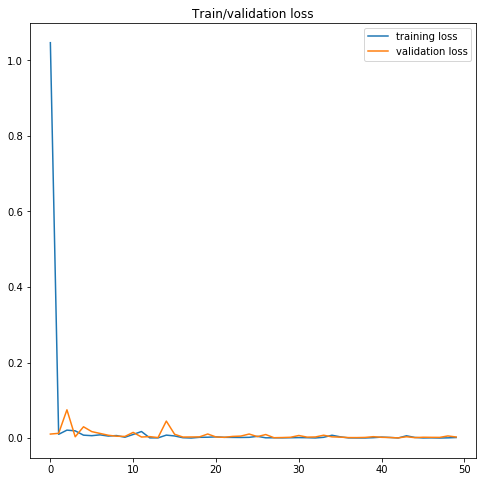

In [19]:
plt.figure(figsize=(8,8))
plt.plot(H.history['loss'], label='training loss')
plt.plot(H.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Train/validation loss')
plt.show()

## Saving model

In [24]:
# save model and architecture to single file
model.save("trained_model.h5")